In [1]:
import wandb
import matplotlib.pyplot as plt
import numpy as np

In [24]:
api = wandb.Api()
runs = api.runs('hiue/lowrank-fedrec-2', {
    "$and": [{
        # 'config.data.name': 'movielens',
        # 'config.dataloader.batch_size': 32,
        'config.data.name': 'lastfm',
        'config.dataloader.batch_size': 16,
        'config.trainer.lr': 5e-3,

        # 'config.data.name': 'foursq-ny',
        # 'config.dataloader.batch_size': 16,
        # 'config.trainer.lr': 7e-3,
        'state': 'finished'}]
})

In [25]:
lora_runs = []
svd_runs = []
normal_runs = []

update_numels = []
all_HR = []
all_NDCG = []
all_loss = []

for run in runs:
    print("Name: {}, Id: {}".format(run.name, run.id))
    if 'lora' in run.name:
        if run.config['model']['init']['lora_rank'] == run.config['model']['init']['lora_alpha']:
            lora_runs.append(run)
        else:
            continue
    elif 'svd' in run.name:
        svd_runs.append(run)
    else:
        normal_runs.append(run)
    update_numels.append(run.summary['update_numel'])
    all_HR.append(run.history()['HR'].max())
    all_NDCG.append(run.history()['NDCG'].max())
    all_loss.append(run.history()['train_loss'].min())

Name: fedmf64-svd16-50-2-82, Id: 3fry8yct
Name: fedmf64_lora16_freezeB-50-2-81, Id: 1nh1f7m7
Name: fedmf16-50-2-80, Id: 8qiv9xfc
Name: fedmf64_lora2_freezeB-50-2-79, Id: 1bwtsjyp
Name: fedmf64-svd2-50-2-78, Id: 1b0inqkc
Name: fedmf2-50-2-76, Id: 15v91rbl
Name: fedmf8-50-2-75, Id: 2vzeeqck
Name: fedmf4-50-2-74, Id: 3gzqjdg9
Name: fedmf64_lora4_freezeB-50-2-42, Id: 2wxlrsno
Name: fedmf64-svd8-50-2-39, Id: 8bj2khgh
Name: fedmf64-svd4-50-2-38, Id: 2a2qiwux
Name: fedmf64_lora8_freezeB-50-2-37, Id: 1ra2awt9
Name: fedmf64_lora4_freezeB-50-2-36, Id: 3ionwp0v
Name: fedmf64-50-2-35, Id: 2ghjgl2f


In [26]:
def scatter_plot(ax, runs, metric, label=None, marker='o', linestyle='dashed', color=None, rescale_x=None):
    x = []
    y = []
    for run in runs:
        x.append(run.summary['update_numel'])
        # y.append(run.summary[metric])
        y.append(run.history()[metric].max())
    ids = np.argsort(x)
    x = np.array(x)[ids]
    y = np.array(y)[ids]
    if rescale_x is not None:
        x = x / rescale_x
    ax.plot(x, y, label=label, marker=marker, linestyle=linestyle, color=color)

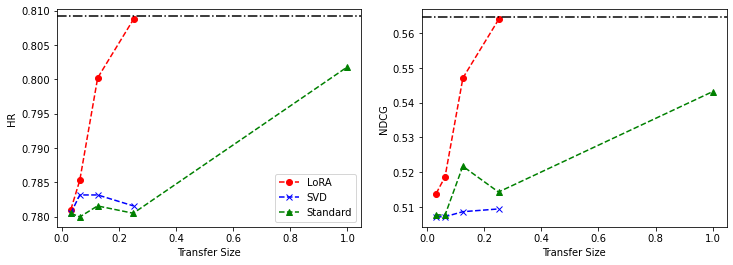

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
scatter_plot(axes[0], lora_runs, 'HR', label='LoRA', marker='o', linestyle='dashed', color='red', rescale_x=max(update_numels))
scatter_plot(axes[0], svd_runs, 'HR', label='SVD', marker='x', linestyle='dashed', color='blue', rescale_x=max(update_numels))
scatter_plot(axes[0], normal_runs, 'HR', label='Standard', marker='^', linestyle='dashed', color='green', rescale_x=max(update_numels))
axes[0].set_xlabel('Transfer Size')
axes[0].set_ylabel('HR')
axes[0].legend()
axes[0].axhline(y=max(all_HR), color='black', linestyle='-.')

scatter_plot(axes[1], lora_runs, 'NDCG', label='LoRA', marker='o', linestyle='dashed', color='red', rescale_x=max(update_numels))
scatter_plot(axes[1], svd_runs, 'NDCG', label='SVD', marker='x', linestyle='dashed', color='blue', rescale_x=max(update_numels))
scatter_plot(axes[1], normal_runs, 'NDCG', label='Standard', marker='^', linestyle='dashed', color='green', rescale_x=max(update_numels))
axes[1].set_xlabel('Transfer Size')
axes[1].set_ylabel('NDCG')
axes[1].axhline(y=max(all_NDCG), color='black', linestyle='-.')


# scatter_plot(axes[2], lora_runs, 'train_loss', label='LoRA', marker='o', linestyle='dashed', color='red', rescale_x=max(update_numels))
# scatter_plot(axes[2], svd_runs, 'train_loss', label='SVD', marker='x', linestyle='dashed', color='blue', rescale_x=max(update_numels))
# scatter_plot(axes[2], normal_runs, 'train_loss', label='Standard', marker='^', linestyle='dashed', color='green', rescale_x=max(update_numels))
# axes[2].set_xlabel('Transfer Size')
# axes[2].set_ylabel('Train loss')

In [30]:
fig.savefig('lastfm_transfer_size_max_metric.pdf', bbox_inches='tight')